# Table of Contents
* [Title/authors](#The-non-Toy-problem)
* [Introduction](#Introduction)
* [Code](#Code)
	* [Retrieve the GW template](#Retrieve-the-GW-template)
	* [Check out the template signal and window it](#Check-out-the-template-signal-and-window-it)
	* [Modify the amplitude of the ringdown of the template to create a faux non-GR perturbation; We will try to recover this perturbation at the end](#Modify-the-amplitude-of-the-ringdown-of-the-template-to-create-a-faux-non-GR-perturbation;-We-will-try-to-recover-this-perturbation-at-the-end)
	* [Create family of templates for match filtering w/ various ringdown amplitude perturbations](#Create-family-of-templates-for-match-filtering-w/-various-ringdown-amplitude-perturbations)
	* [add noise to a perturbed template to make some faux data](#add-noise-to-a-perturbed-template-to-make-some-faux-data)
	* [match filtering function](#match-filtering-function)
	* [SNR distribution](#SNR-distribution)
	* [Mass distribution](#Mass-distribution)
	* [Match filter the faux data against the template bank for different noise_levels](#Match-filter-the-faux-data-against-the-template-bank-for-different-noise_levels)
	* [Plot the noise level and recovered amplitude deviations](#Plot-the-noise-level-and-recovered-amplitude-deviations)
	* [Match filter the faux data against the template bank for different SNRs](#Match-filter-the-faux-data-against-the-template-bank-for-different-SNRs)
	* [Plot the SNR pdfs for stacked data](#Plot-the-SNR-pdfs-for-stacked-data)
	* [try trimming the SNR pdfs before stacking them & get the widths](#try-trimming-the-SNR-pdfs-before-stacking-them-&-get-the-widths)
	* [Plot the recovered amplitude deviations and number of stacked and trimmed events](#Plot-the-recovered-amplitude-deviations-and-number-of-stacked-and-trimmed-events)


# The non-Toy problem


Missy McIntosh

Advised by Craig Cahillane, Alan Weinstein, Kent Blackburn

# Introduction

Current gravitational wave (GW) analysis is dominated by systematic error. Stacking many GW signals may increase the SNR/reduce the systematic error to the point that statistical error becomes the primary source of error. However, calibration errors (CEs) provide a significant contribution to these systematic errors. It's unknown whether these CEs are great enough to disguise any non-GR perturbations that may exist in GW signals which would otherwise be revealed by stacking many GW signals. If they are great enough, it is unknown if implementing a calibration error model would reduce the CE impact enough to see these non-GR perturbations. This ipython notebook is a test of concept for these ideas: What calibration accuracy do we need before statistical error dominates? For large SNR, how well can we constrain a parameter? With an additional distorted calibration, how well can we constrain that parameter? Which parameters in Craig's model are impacted by calibration errors the most? For which masses does the CE matter? Which parameters should we do our best to measure? How well should we measure them for N events?

# Code

In [1]:
import os 
import sys
path = '/Users/mmcintosh/GoogleDrive/LIGO/tutorials/'
sys.path.insert(0, path)
os.chdir(path)

import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
# I used python-modernize on this so it works with 3.4
import readligo as rl

## Retrieve the GW template

In [2]:
# Get the boxing day template and matched filter engine from losc event tutorial, 
# https://losc.ligo.org/s/events/GW151226/LOSC_Event_tutorial_GW151226.html

fnjson = "O1_events.json"
events = json.load(open(fnjson,"r"))
eventname = 'GW151226' 

event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
NFFT = 4*fs
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal


# get the template
f_template = h5py.File(fn_template, "r")
#extract metadata from the template file:
template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()

# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

_, time, _ = rl.loaddata(fn_L1, 'L1')

# complex template:
ctemplate = (template_p + template_c*1.j) 
ttime = time-time[0]-template_offset

# whiten the templates:
#template_p_whiten = whiten(template_p,psd_H1,dt)
#template_c_whiten = whiten(template_c,psd_H1,dt)
#template_p_whitenbp = filtfilt(bb, ab, template_p_whiten)
#template_c_whitenbp = filtfilt(bb, ab, template_c_whiten)


#time = np.linspace(0,16, len(template_p))
#ttime = time-time[0]-template_offset
dt = time[1] - time[0]
GRtemplate = (template_p + template_c*1.j) 
data = (template_p + template_c*1.j) 

## Check out the template signal and window it

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


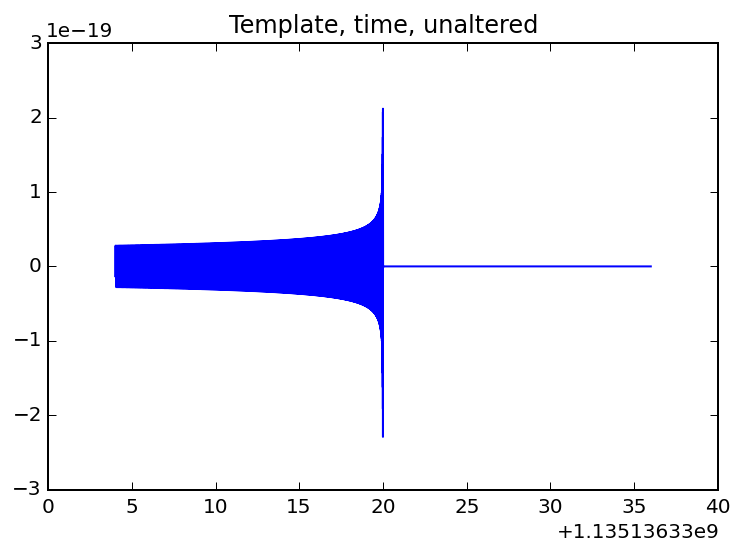

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/fft/fftpack.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)


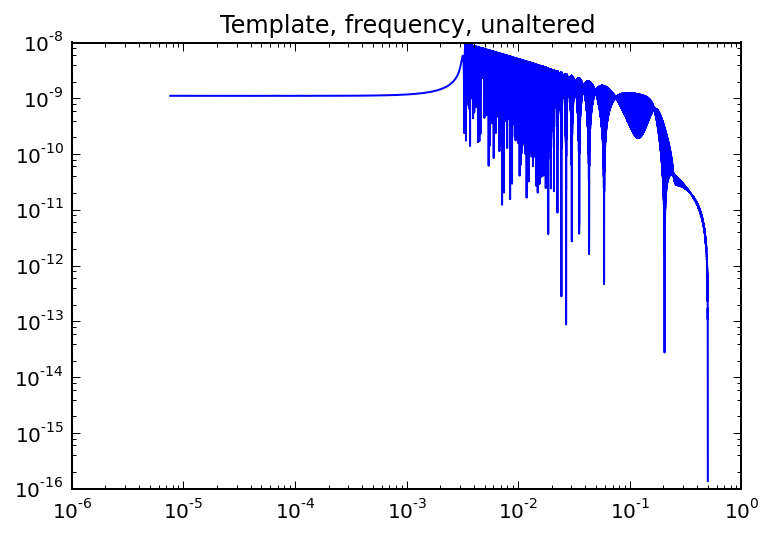

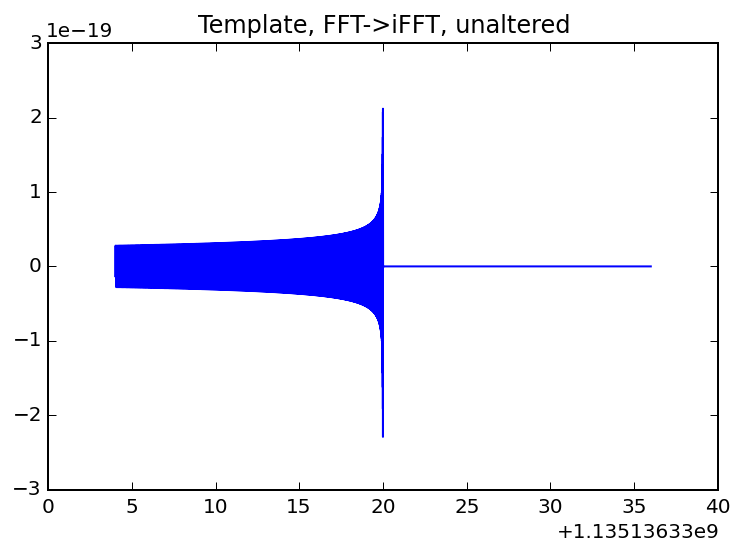

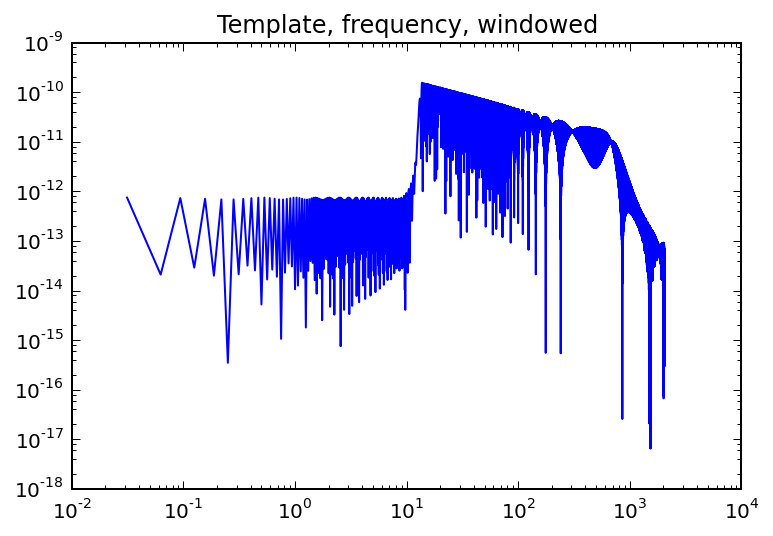

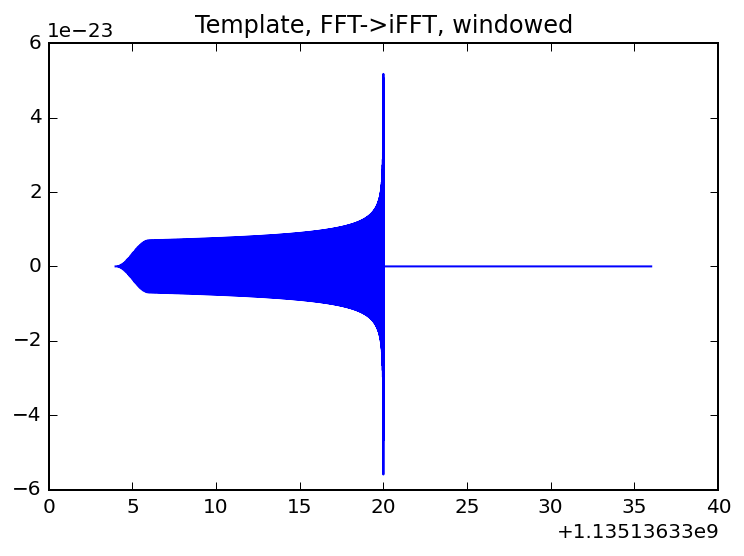

In [3]:

plt.plot(time, data)
plt.title('Template, time, unaltered')
plt.show()
freq_data = np.fft.rfft(data)
infreq = np.fft.rfftfreq(data.size)
plt.title('Template, frequency, unaltered')
plt.loglog(infreq, np.sqrt(freq_data))
plt.show()

plt.title('Template, FFT->iFFT, unaltered')
plt.plot(time, np.fft.irfft(freq_data))
plt.show()

#data_bp = filtfilt(bb, ab, data)
#plt.title('Template, time, bandpassed')
#plt.plot(time, data_bp)
#plt.show() 

# Take the Fourier Transform (FFT) of the template (with dwindow)
dwindow = signal.tukey(data.size, alpha=1./8)
datafreq = np.fft.rfftfreq(data.size) * fs
data_fft = np.fft.rfft(data*dwindow) / fs
plt.title('Template, frequency, windowed')
plt.loglog(datafreq, np.sqrt(data_fft))
plt.show()

processed_data = np.fft.irfft(data_fft)
plt.title('Template, FFT->iFFT, windowed')
plt.plot(time, processed_data)
plt.show()

## Modify the amplitude of the ringdown of the template to create a faux non-GR perturbation
We will try to recover this perturbation at the end

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


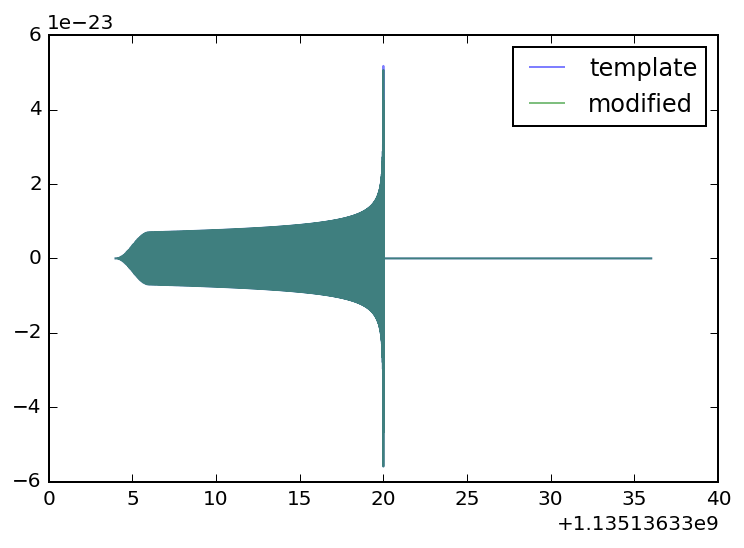

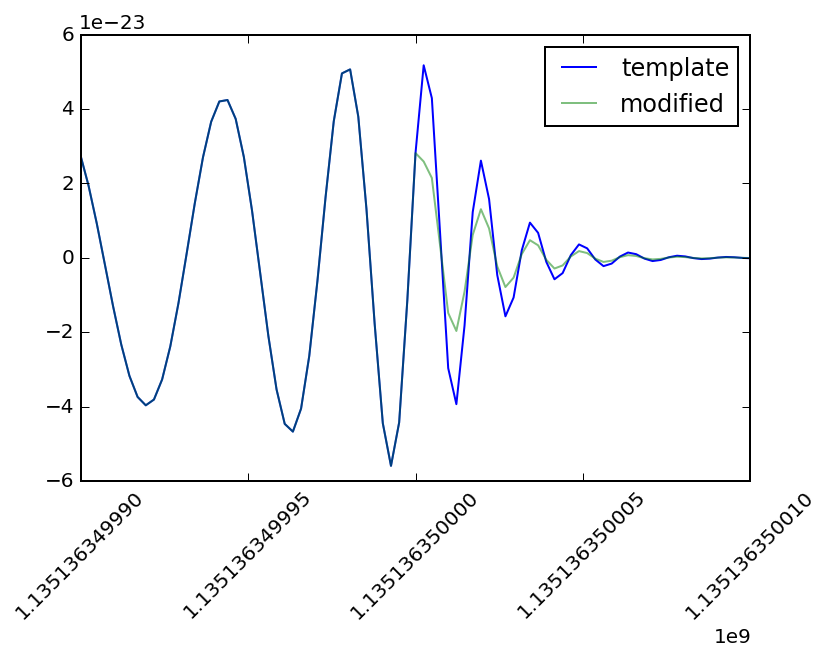

In [4]:
# modify the amplitude of the template
# this is my code now

GRtemplate = processed_data

import cmath as c
def shiftphase(rectangular_coords, phase_shift):
    r, phi = c.polar(rectangular_coords)
    shifted_phi = phi + phase_shift
    shifted_rectangular = c.rect(r,shifted_phi)
    return(shifted_rectangular)
def modifyringdown(template,amplitude,phase):
    max_index = np.argmax(template)
    mod_ringdown = [shiftphase(x,phase)*amp for x in GRtemplate[max_index:]]
    mod_template = np.concatenate([template[:max_index],mod_ringdown])
    return(mod_template)

# 50% decrease in amplitude
amp = 0.5
phase = 0
mod_template = modifyringdown(GRtemplate,amp,phase)



scale = 1.13513633*10**9
plt.plot(time, GRtemplate, alpha = 0.5, label="template")
plt.plot(time,mod_template, alpha=0.5,label="modified")
#plt.ylim(-2.5*scale,2.5*scale)
plt.legend(loc=0)
plt.show()

ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.xticks(rotation=45)
ax.plot(time, GRtemplate, label="template")
ax.plot(time,mod_template, alpha=0.5,label="modified")
#print(scale, scale+3)
plt.xlim(scale+19.99,scale+20.01)
#plt.xlim(7.999,8.005)
plt.legend(loc=0)
plt.show()

## Create family of templates for match filtering w/ various ringdown amplitude perturbations

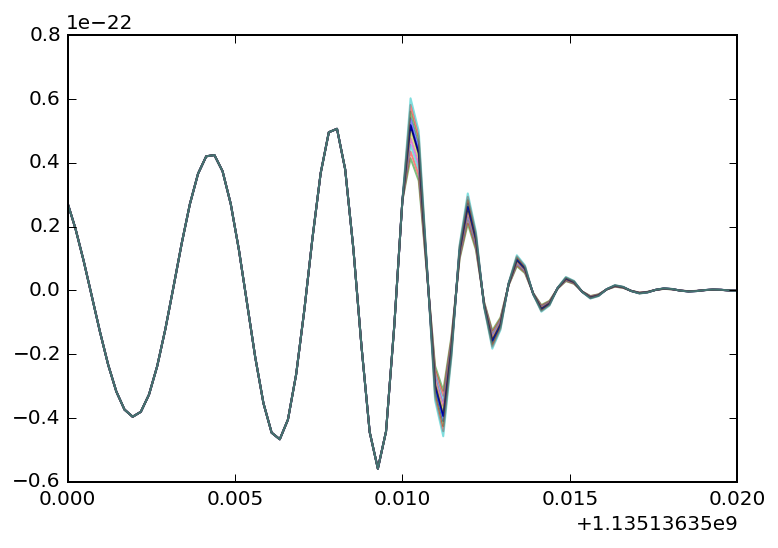

In [5]:
# number of templates
n = 100

# make a family of templates
class Template(object):
    number = 0
    timeseries = []
    amp = 0
    phase = 0

    def __init__(self, number, timeseries, amp, phase):
        self.number = number
        self.timeseries = timeseries
        self.amp = amp
        self.phase = phase

def make_template(number, timeseries, amp, phase):
    template = Template(number, np.real(timeseries), amp, phase)
    return(template)

amps = np.linspace(0.8,1.2,n)
phases = np.zeros(n)#np.linspace(0,2*np.pi,n)

#amps = np.linspace(0.5,1.5,n)
#phases = np.pi/(np.linspace(0.1,2,n))

plt.plot(time, GRtemplate, label="template")
templates = []
i = 0
for amp in amps:
    #for phase in phases: 
    timeseries = modifyringdown(GRtemplate,amp,phase)
    template = make_template(i,timeseries,amp,phase)
    templates.append(template)
    if (i % 10) == 0:
        plt.plot(time,template.timeseries, alpha=0.5)
    i+=1
#plt.ylim(-10*scale,10*scale)
#plt.xlim(7.999,8.005)
plt.xlim(scale+19.99,scale+20.01)
plt.show()

## add noise to a perturbed template to make some faux data

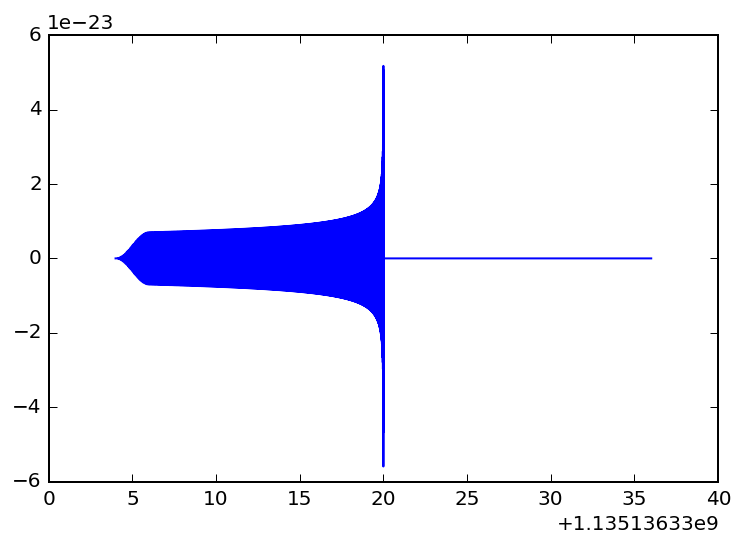

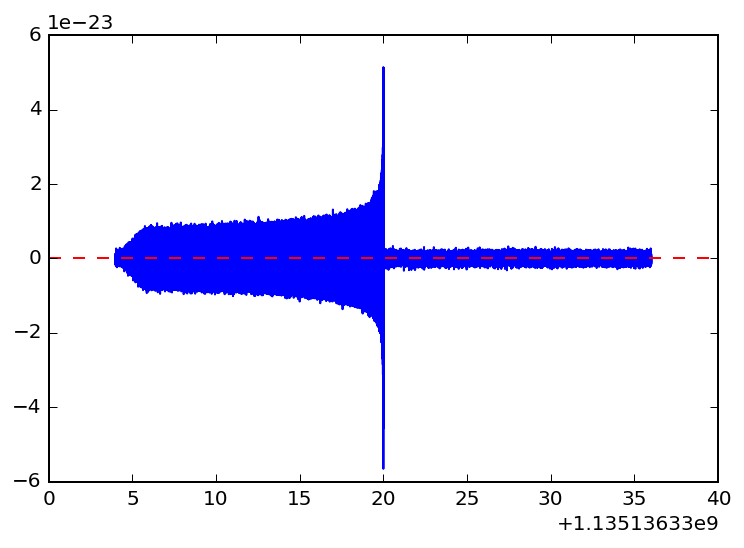

In [6]:
# now let's add some white noise
def whitenoise(template, noise_level):
    if noise_level==0:
        return(template)
    else:
        scale = 10**-23
        # transform to freq domain
        Nt = len(template)
        freqs = np.fft.rfftfreq(Nt, dt)
        hf = np.fft.rfft(template)
        white_noise = np.random.uniform(0,noise_level,len(hf))*scale
        noisy_data = hf+white_noise
        data = np.fft.irfft(noisy_data, n=len(template))
        data[0] = 0
    return(data)
plt.plot(time, GRtemplate)
plt.show()
noisy_data = whitenoise(GRtemplate, 100)
plt.plot(time, np.real(noisy_data))
plt.axhline(np.mean(noisy_data),xmin=0, xmax=450,linestyle='--',color='r')
plt.show()

#plt.xlim(scale+19.99,scale+20.01)

## match filtering function

In [7]:
# this whole function is from 
# https://losc.ligo.org/s/events/GW151226/LOSC_Event_tutorial_GW151226.html

def matchfiltering(template, data):
    
     # -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
    #   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
    NFFT = 4*fs
    psd_window = np.blackman(NFFT)
    # and a 50% overlap:
    NOVL = NFFT/2

    # define the complex template, common to both detectors:
    #template = (template_p + template_c*1.j) 

    # We will record the time where the data match the END of the template.
    etime = time+template_offset
    # the length and sampling rate of the template MUST match that of the data.
    datafreq = np.fft.fftfreq(template.size)*fs
    df = np.abs(datafreq[1] - datafreq[0])

    # to remove effects at the beginning and end of the data stretch, window the data
    # https://en.wikipedia.org/wiki/Window_function#Tukey_window
    try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
    except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

    # prepare the template fft.
    template_fft = np.fft.fft(template*dwindow) / fs    

    # -- Calculate the PSD of the data.  Also use an overlap, and window:
    data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(data*dwindow) / fs

    # -- Interpolate to get the PSD values at the needed frequencies
    power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = time[indmax]
    SNRmax = SNR[indmax]


            
    return(SNRmax)

## SNR distribution

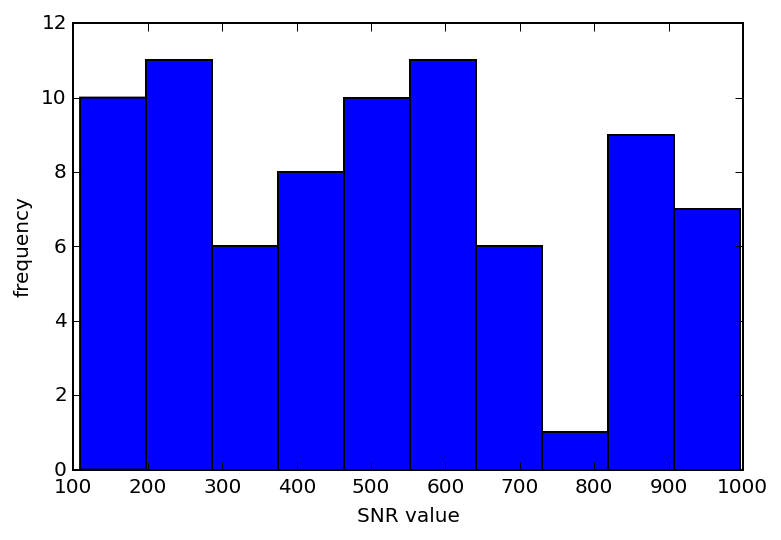

In [8]:
# SNR distribution 1/SNR^4 minimum value is ~11 (threshhold for detection)
# right now, my code only works for large SNR for some reason
min_snr = 100
scale_factor = 1000

snr_distribution = scale_factor*np.random.power(3/4., size=100)
snr_distribution = snr_distribution[np.where(snr_distribution > min_snr)[0]]
plt.hist(snr_distribution)
plt.xlabel("SNR value")
plt.ylabel("frequency")
plt.show()

amplitude perturbation: 6.66666666667
94642.56848632936


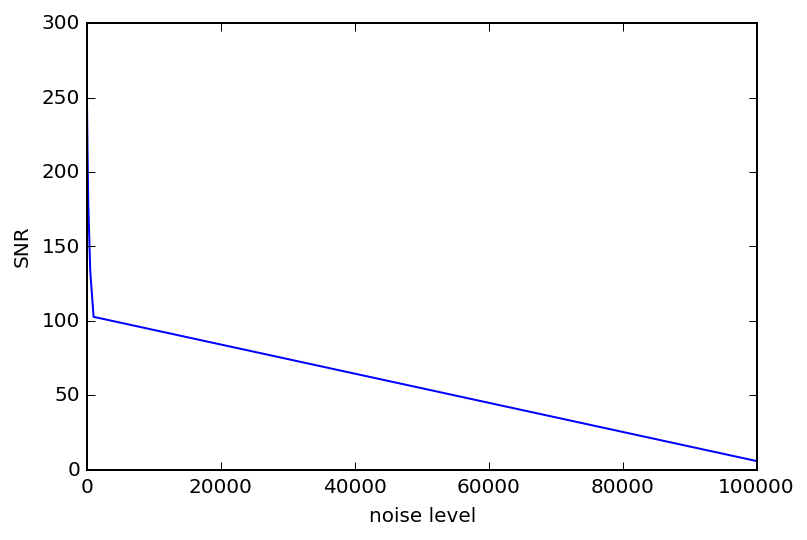

In [9]:
# I have this scaling factor, noise_level, for how much white noise I'm adding
# we tend to detect signals with a SNR of ~11
# what the relationship between input noise_level and output SNR? 
# I need to generate signals with resulting SNR following the distribution above

noise_levels = [1, 5, 10, 50, 100, 200, 500, 1000, 100000]

number = int(len(templates)/1.5)
datatemplate = templates[number]
print('amplitude perturbation:',(datatemplate.amp-1)*100)

meansnrs = []
for noise_level in noise_levels: 
    data = whitenoise(datatemplate.timeseries, noise_level)
    meansnr = np.mean([matchfiltering(template.timeseries,data) for template in templates])
    meansnrs.append(meansnr)
    
plt.plot(noise_levels, meansnrs)
plt.xlabel('noise level')
plt.ylabel('SNR')

def snr_to_noise_level(snr, meansnrs, noise_levels):
    noise_level = np.interp(snr, meansnrs[::-1],noise_levels[::-1])
    return(noise_level)
print(snr_to_noise_level(11, meansnrs, noise_levels))

## Mass distribution

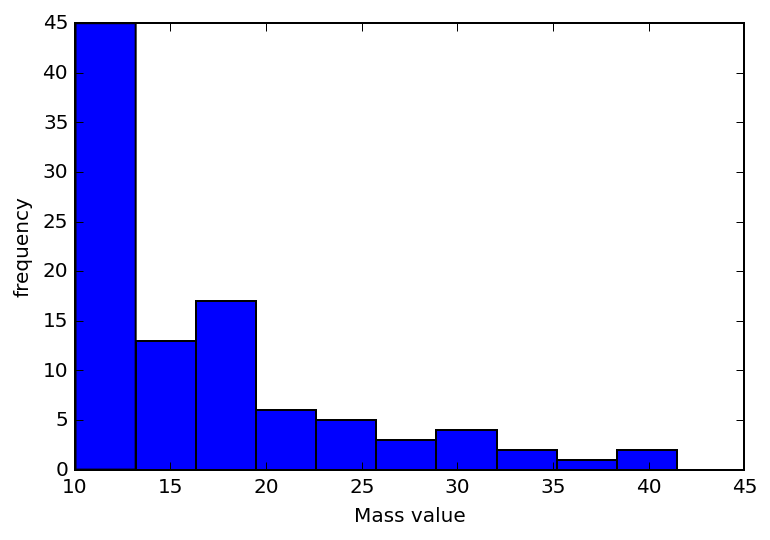

In [10]:
#m^-1 power law from 5 to 45 solar masses for a mass distribution

min_mass = 5.
max_mass = 45.

mass_distribution = (1/(np.random.power(2, size=100)))*10
mass_distribution = mass_distribution[np.where(mass_distribution > min_mass)[0]]
mass_distribution = mass_distribution[np.where(mass_distribution < max_mass)[0]]
plt.hist(mass_distribution)
plt.xlabel("Mass value")
plt.ylabel("frequency")
plt.show()

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


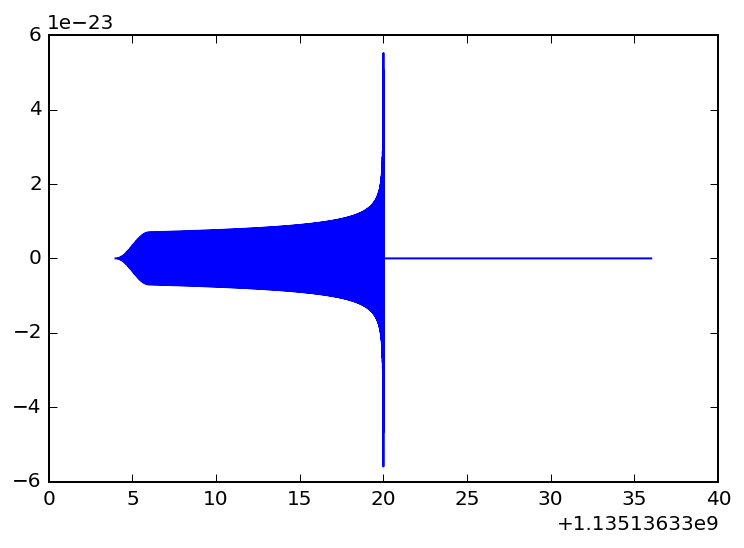

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


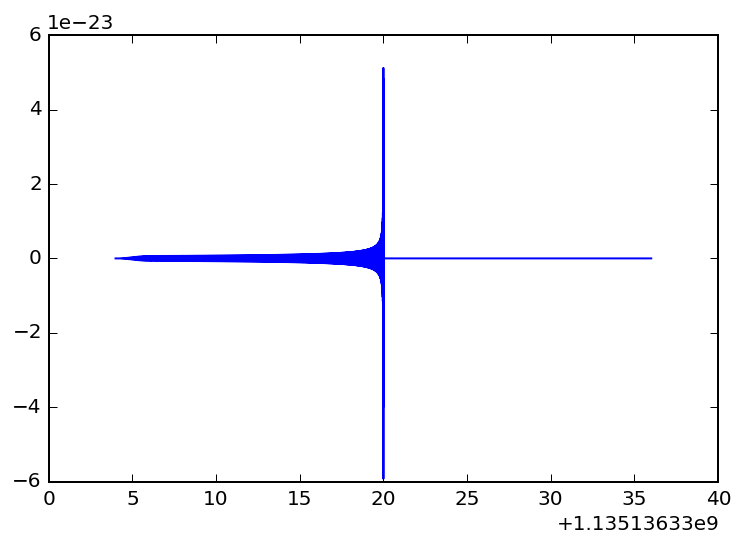

In [11]:
# massscaling 

def scale_waveform(m1,m2,template):
    # original template is 14.2 and 7.5 solar masses
    # total mass
    factor = 5**10.5
    m_tot = m1 + m2
    # symmetric mass ratio
    nu = (m1 * m2)/(m_tot)
    # chirp mass
    m_chirp = nu**(3/5)*m_tot
    r = 1/factor
    
    # transform to freq domain
    Nt = len(template)
    freqs = np.fft.fftfreq(Nt, dt)
    hf = np.fft.fft(template)
    modified_amps = []
    for i,freq in enumerate(freqs): 
        # orbital angular frequency
        omega = 2*np.pi*freq
        # amplitude
        amp = 1/r * m_chirp**(5/3) * omega**(2/3)
        modified_amps.append(hf[i]*amp)
    
    
        
    # interpolate? 
    bol = [~np.isnan(modified_amps)][0]
    modified_amps = np.asarray(modified_amps)[bol]
    freqs = freqs[bol]
    temp = interp1d(freqs, modified_amps,fill_value='extrapolate')
    # then transform back
    modified_template = np.fft.ifft(temp(modified_amps), n=Nt)

    return(modified_template)


temp = scale_waveform(14.2,7.5, datatemplate.timeseries)
plt.plot(time,datatemplate.timeseries)
plt.show()
plt.plot(time,temp)
plt.show()

In [12]:
# ok, well that doesn't work yet

## Match filter the faux data against the template bank for different noise_levels

In [13]:
snrs_arr = []
amps = [template.amp for template in templates]
damps = list(np.asarray(amps)-1)
#phases = [template.phase for template in templates]
for noise_level in noise_levels: 
    
    # scale template by mass
    #m1, m2 = np.random.choice(mass_distribution, 2)
    #print(m1,m2)
    #scaled_template = scale_waveform(m1,m2, datatemplate.timeseries)
    scaled_template = datatemplate.timeseries
    #plt.plot(time,scaled_template)
    #plt.show()
    
    # add white noise
    data = whitenoise(scaled_template, noise_level)
    #plt.plot(time, data)
    #plt.show()
    snrs = [matchfiltering(template.timeseries,data) for template in templates]
    snrs_arr.append(snrs)
    

## Plot the noise level and recovered amplitude deviations

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


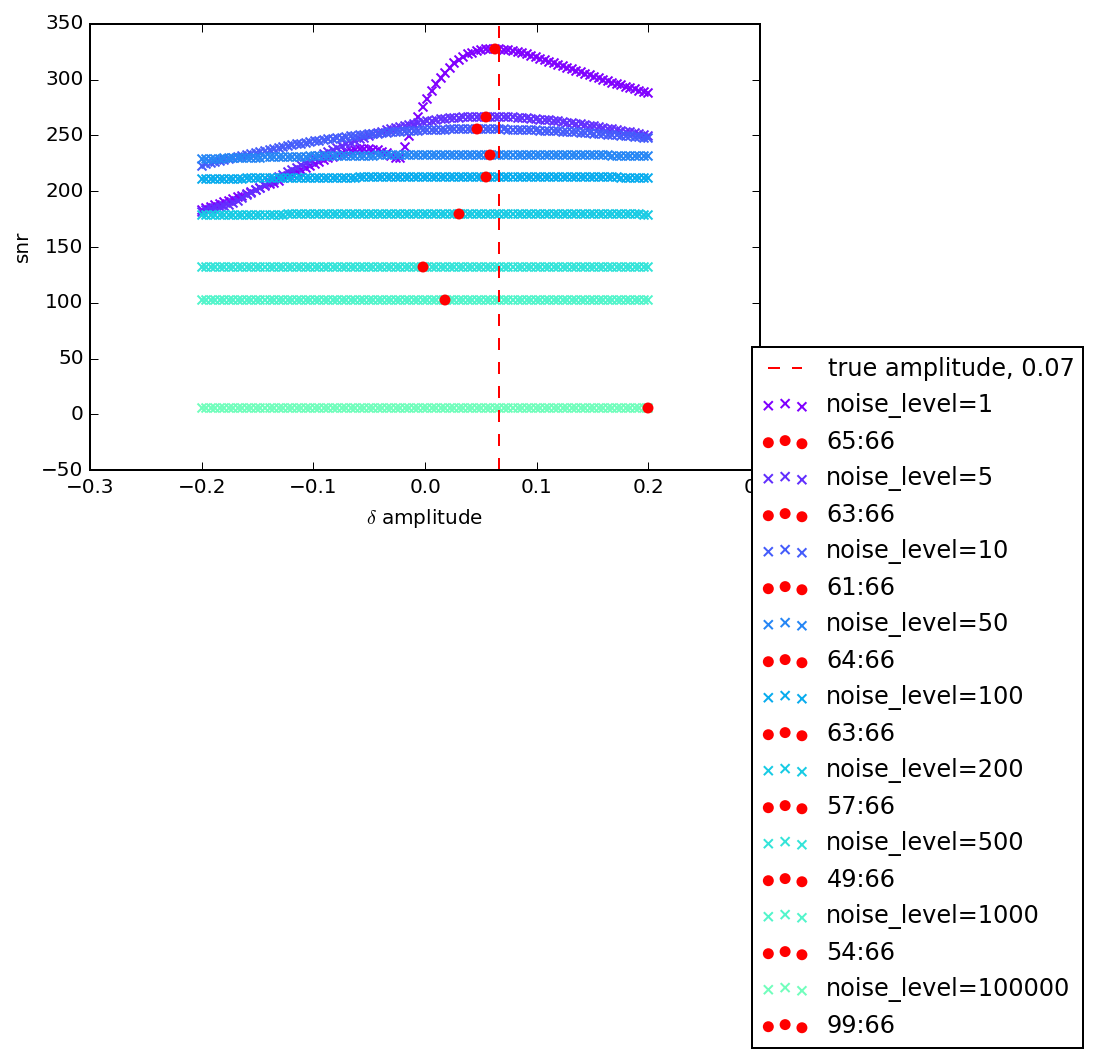

In [14]:
# plotting
from matplotlib.pyplot import cm 
color=iter(cm.rainbow(np.linspace(0,1,len(noise_levels*2))))

for i,noise_level in enumerate(noise_levels):
    c=next(color)
    plt.scatter(damps,snrs_arr[i], marker='x', c=c, label="noise_level={0}".format(noise_level))
    plt.scatter(damps[np.argmax(snrs_arr[i])],np.max(snrs_arr[i]),color='r', 
                label='{0}:{1}'.format(templates[np.argmax(snrs_arr[i])].number, number))
    
plt.axvline(datatemplate.amp-1,ymin=0, ymax=450,linestyle='--',color='r', 
            label="true amplitude, {0:.2f}".format(datatemplate.amp-1))
plt.ylabel('snr')
plt.xlabel(r'$\delta$ amplitude')
plt.legend(bbox_to_anchor=(0., 0.2, 1.5, .102))
plt.show()

In [15]:
# it looks like after noise_level = 50/SNR = 250, the deviation is not well recovered :( 

## Match filter the faux data against the template bank for different SNRs

In [16]:
N_events = 50
snr_noise_levels = np.random.choice(snr_distribution, N_events)

snrs_arr = []
phases_arr = []
amps = [template.amp for template in templates]
damps = list(np.asarray(amps)-1)
for n in snr_noise_levels: 
    #m1, m2 = np.random.choice(mass_distribution, 2)
    scaled_template = datatemplate.timeseries #scale_waveform(m1,m2, datatemplate.timeseries)
    noise = snr_to_noise_level(n, meansnrs, noise_levels)
    data = whitenoise(scaled_template, noise)
    snrs = [matchfiltering(template.timeseries,data) for template in templates]
    snrs_arr.append(snrs)

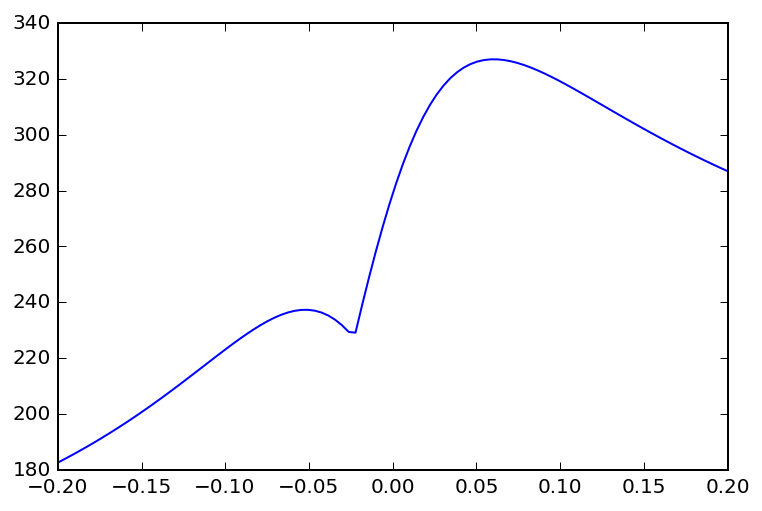

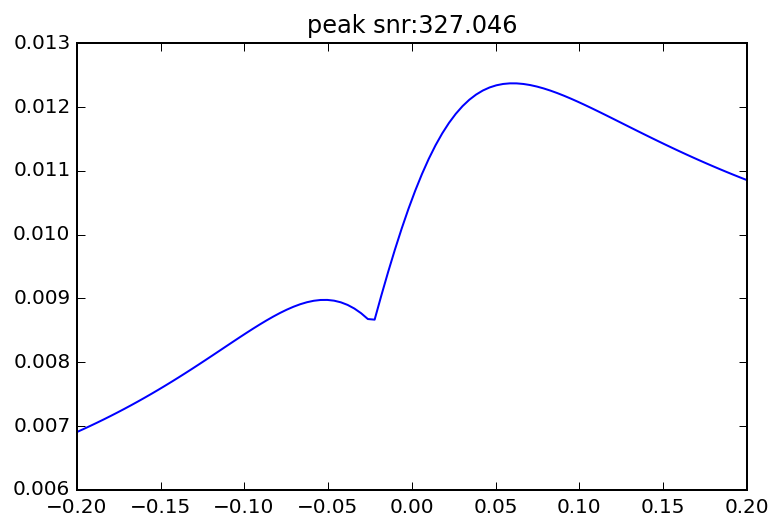

1.0


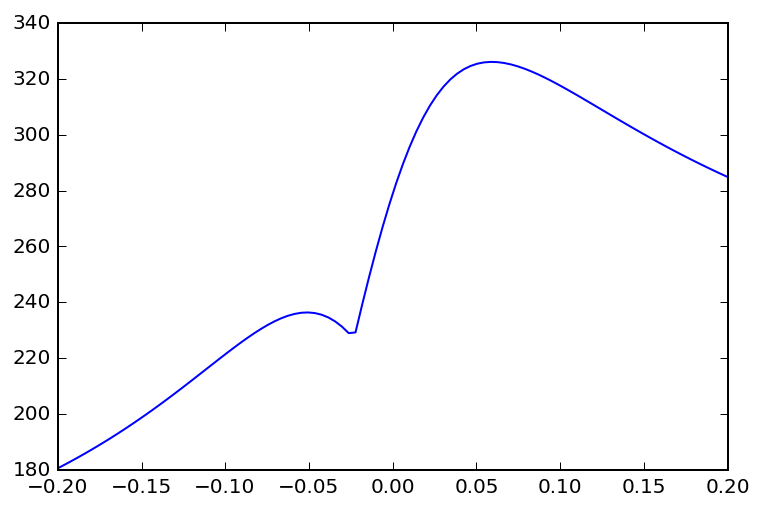

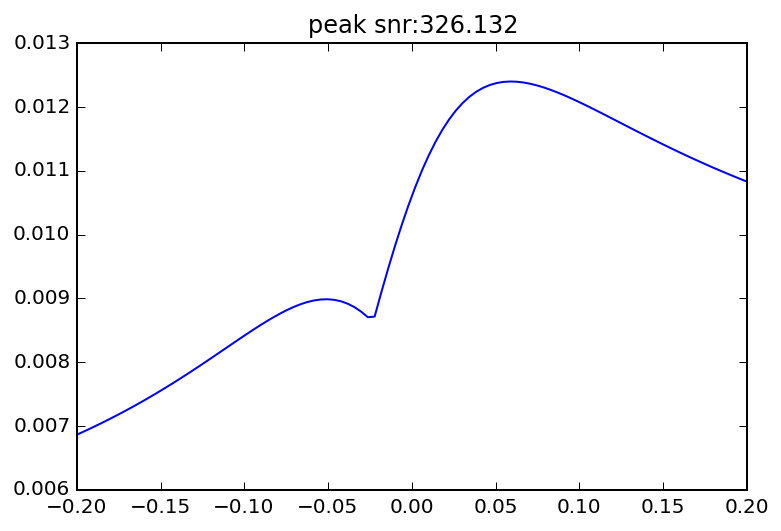

1.0


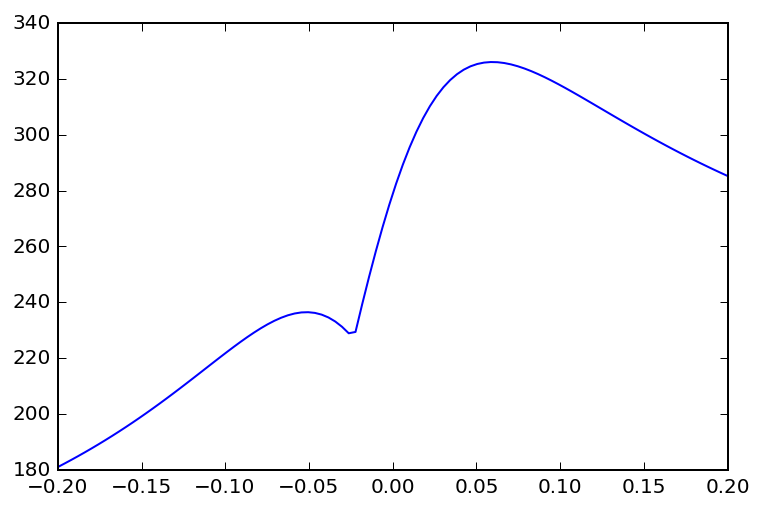

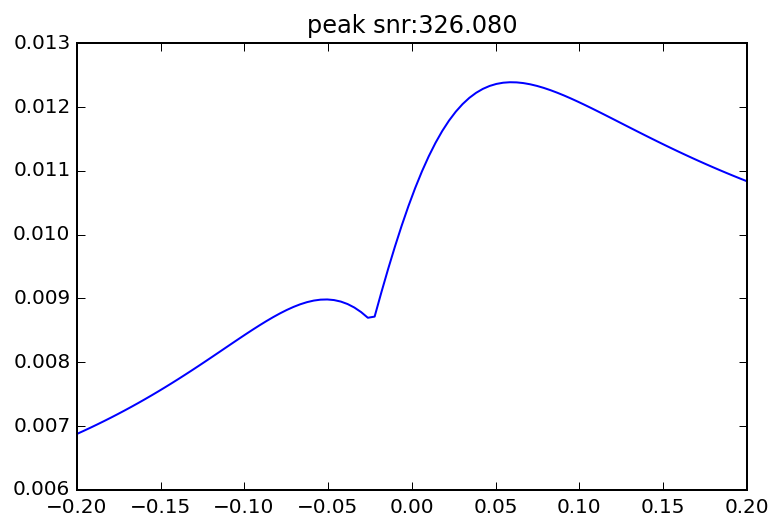

1.0
1.0


In [17]:
# normalize snr into a pdf
for snr in snrs_arr[:3]: 
    # plot it unnormed
    plt.plot(damps, snr)
    plt.show()
    
    # plot it normed
    plt.title('peak snr:{0:.3f}'.format(np.max(snr)))
    norm = 1/np.sum(snr)
    plt.plot(damps, np.array(snr)*norm)
    plt.show()
    
    # check that it adds up to 1
    print(np.sum(np.array(snr)*norm))
    
normed_snrs_arr = [np.array(snr)/np.sum(snr) for snr in snrs_arr]

# check that all add up to 1
print(np.sum(normed_snrs_arr)/len(normed_snrs_arr))

## Plot the SNR pdfs for stacked data

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


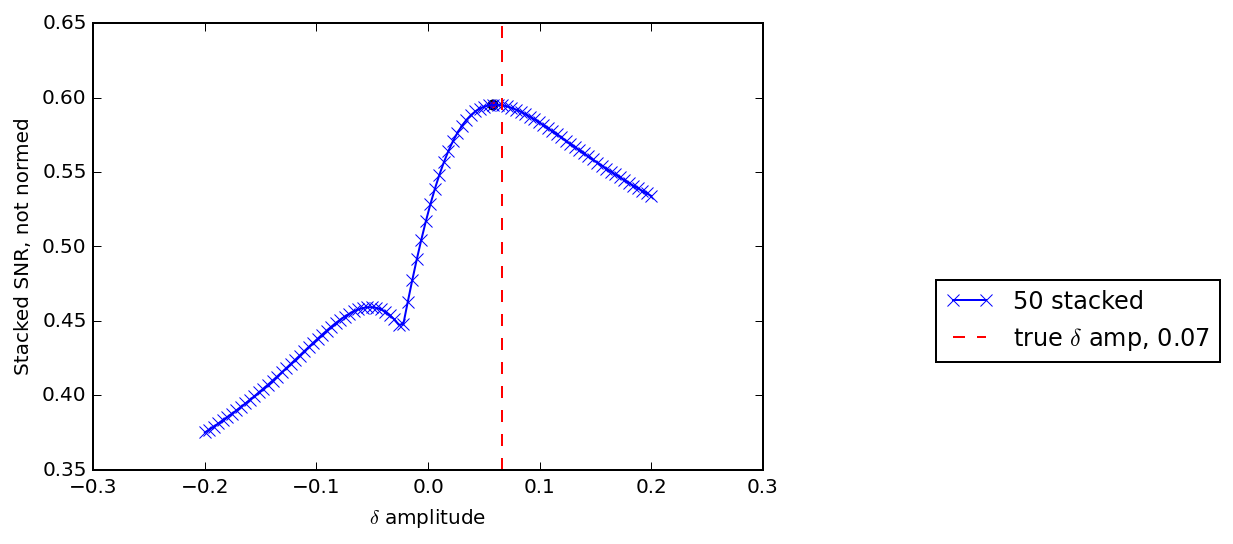

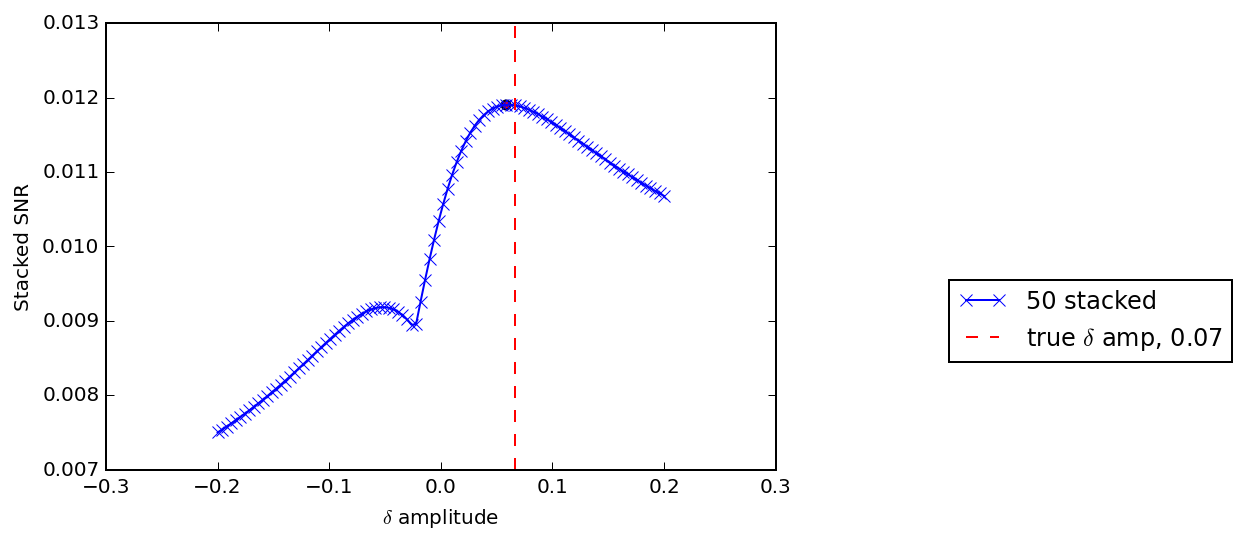

In [18]:
# stacking the PDFs

stacked = [np.sum(i) for i in zip(*normed_snrs_arr)]
plt.plot(damps,stacked, marker='x', c=c, label='{0} stacked'.format(np.shape(snrs_arr)[0]))
plt.scatter(damps[np.argmax(stacked)],np.max(stacked), c='r')
plt.axvline(datatemplate.amp-1,ymin=0, ymax=450,linestyle='--',color='r', label="true $\delta$ amp, {0:.2f}".format(datatemplate.amp -1))
plt.ylabel('Stacked SNR, not normed')
plt.xlabel(r'$\delta$ amplitude')
plt.legend(bbox_to_anchor=(0., 0.35, 1.7, .102))
plt.show()    
    
# stacking the PDFs

stacked = [np.sum(i) for i in zip(*normed_snrs_arr)]
stacked = np.array(stacked)/len(snrs_arr)
plt.plot(damps,stacked, marker='x', c=c, label='{0} stacked'.format(np.shape(snrs_arr)[0]))
plt.scatter(damps[np.argmax(stacked)],np.max(stacked), c='r')
plt.axvline(datatemplate.amp-1,ymin=0, ymax=450,linestyle='--',color='r', label="true $\delta$ amp, {0:.2f}".format(datatemplate.amp -1))
plt.ylabel('Stacked SNR')
plt.xlabel(r'$\delta$ amplitude')
plt.legend(bbox_to_anchor=(0., 0.35, 1.7, .102))
plt.show()

## try trimming the SNR pdfs before stacking them & get the widths

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


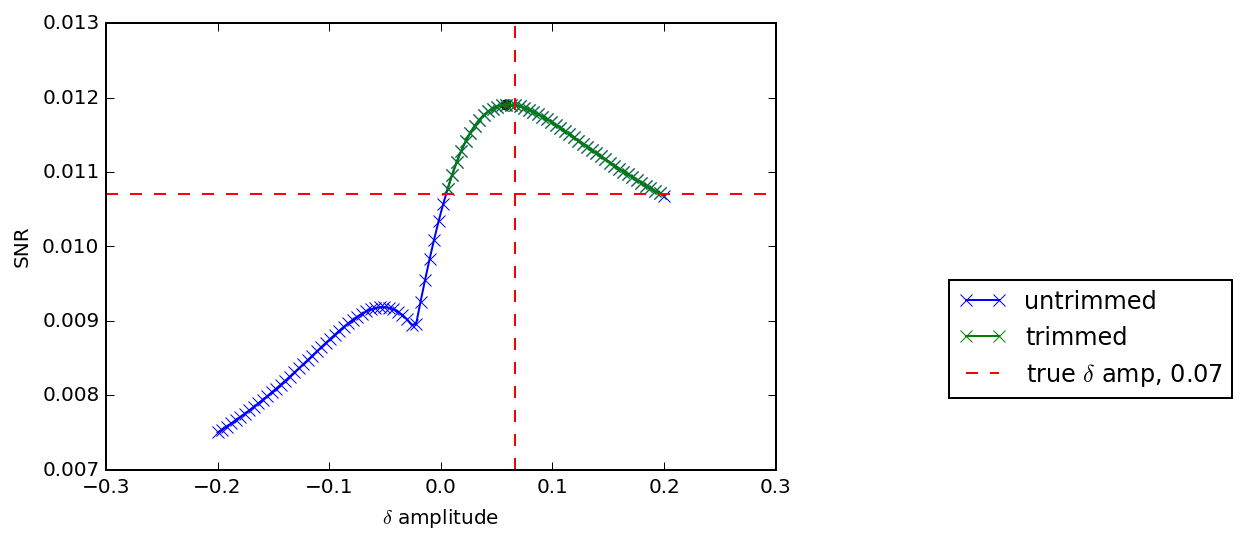

0.110219872207


In [27]:
def trim(snrarray, damps, d=1.07, plots=False): 
# trim the tails, take the RMS deviation from the peak, or something like that
    meanvalue = np.mean(snrarray)
    #d = 1.01 # 0.95 to 1.05
    trimmed = [(i,s) for i,s in enumerate(snrarray) if s > d*meanvalue]
    try: 
        trimmed_idx, trimmed_snrs = map(np.asarray,list(zip(*trimmed)))
    except:
        d=1
        trimmed = [(i,s) for i,s in enumerate(snrarray) if s > d*meanvalue]
        trimmed_idx, trimmed_snrs = map(np.asarray,list(zip(*trimmed)))
    trimmed_damps = [damps[i] for i in trimmed_idx]
    if plots: 
        plt.plot(damps,snrarray, marker='x', c='k', label='untrimmed')
        plt.plot(trimmed_damps,trimmed_snrs, marker='x', c='c', label='trimmed')
        plt.axhline(d*meanvalue,xmin=0, xmax=450,linestyle='--',color='r')
        plt.scatter(trimmed_damps[np.argmax(trimmed_snrs)],np.max(trimmed_snrs), c='r')
        plt.axvline(datatemplate.amp-1,ymin=0, ymax=450,linestyle='--',color='r', 
                    label="true $\delta$ amp, {0:.2f}".format(datatemplate.amp -1))
        plt.ylabel('SNR')
        plt.xlabel(r'$\delta$ amplitude')
        plt.legend(bbox_to_anchor=(0., 0.35, 1.7, .102))
        plt.show()
    return(trimmed_damps,trimmed_snrs)


def rms(array): 
    return(np.sqrt(np.mean([a**2 for a in array])))

def getwidth(array):
    peakvalue = np.max(array)
    deviations = [(a - peakvalue) for a in array]
    return(rms(deviations))

trimmed_damps, trimmed_snrs = trim(stacked,damps,plots=True)
width = getwidth(trimmed_damps)
print(width)


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


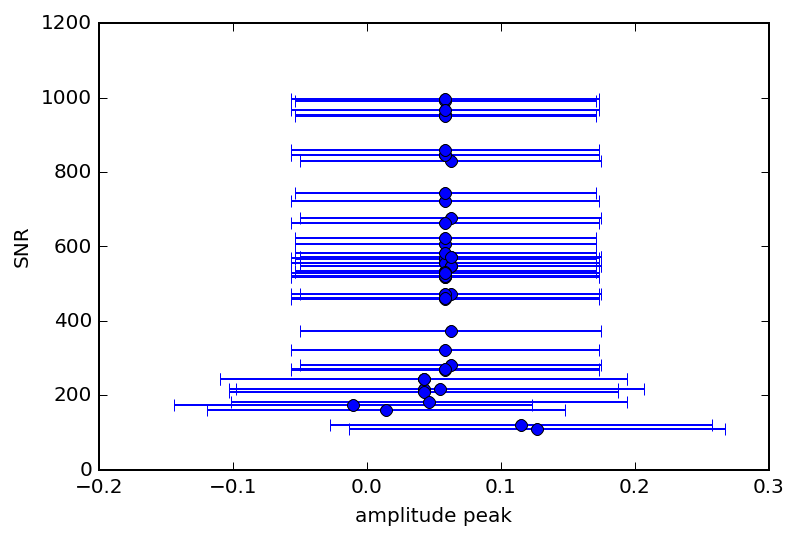

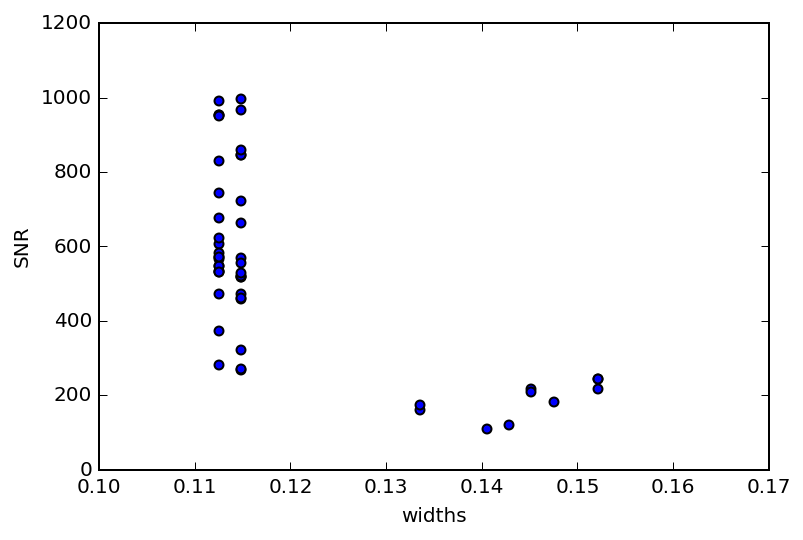

In [28]:
widths = []
peaks = []
for snr in snrs_arr: 
    trimmed_damps, trimmed_snrs = trim(snr,damps)
    peak = trimmed_damps[np.argmax(trimmed_snrs)]
    peaks.append(peak)
    width = getwidth(trimmed_damps)
    widths.append(width)
    
plt.scatter(peaks,snr_noise_levels)
plt.errorbar(peaks, snr_noise_levels, xerr=widths,fmt='o')
plt.xlabel('amplitude peak')
plt.ylabel('SNR')
plt.show()

plt.scatter(widths,snr_noise_levels)
plt.xlabel('widths')
plt.ylabel('SNR')
plt.show()

In [21]:
# it looks like the widths go to a constant for SNRS > 200

## Plot the recovered amplitude deviations and number of stacked and trimmed events

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.]
0 / 50 0
0.000138070299973


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


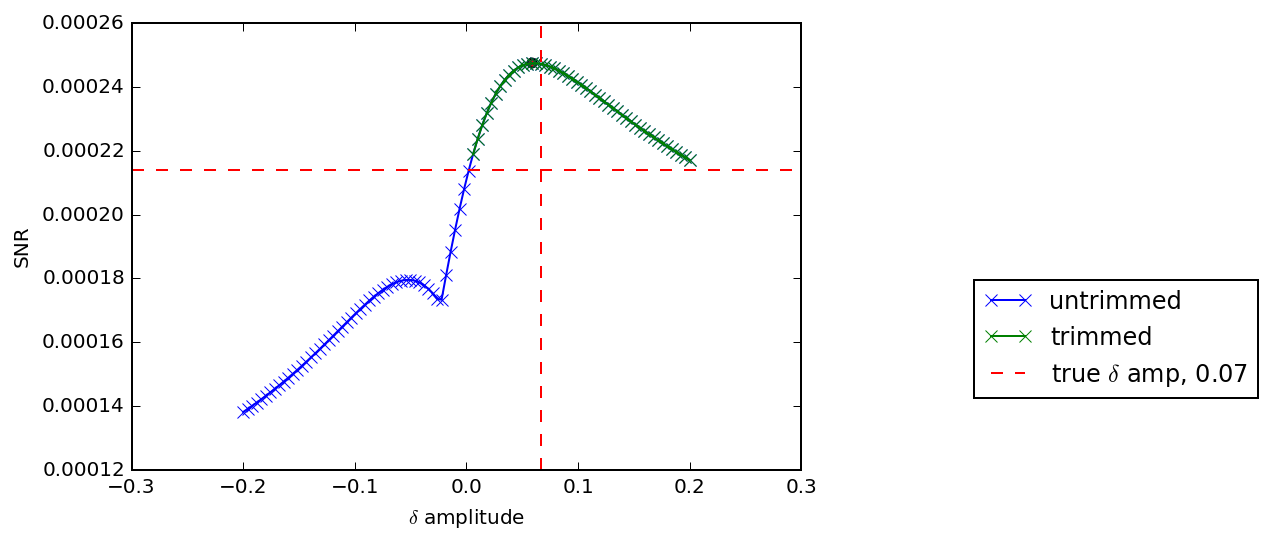

5 / 50 5
0.000749833769116


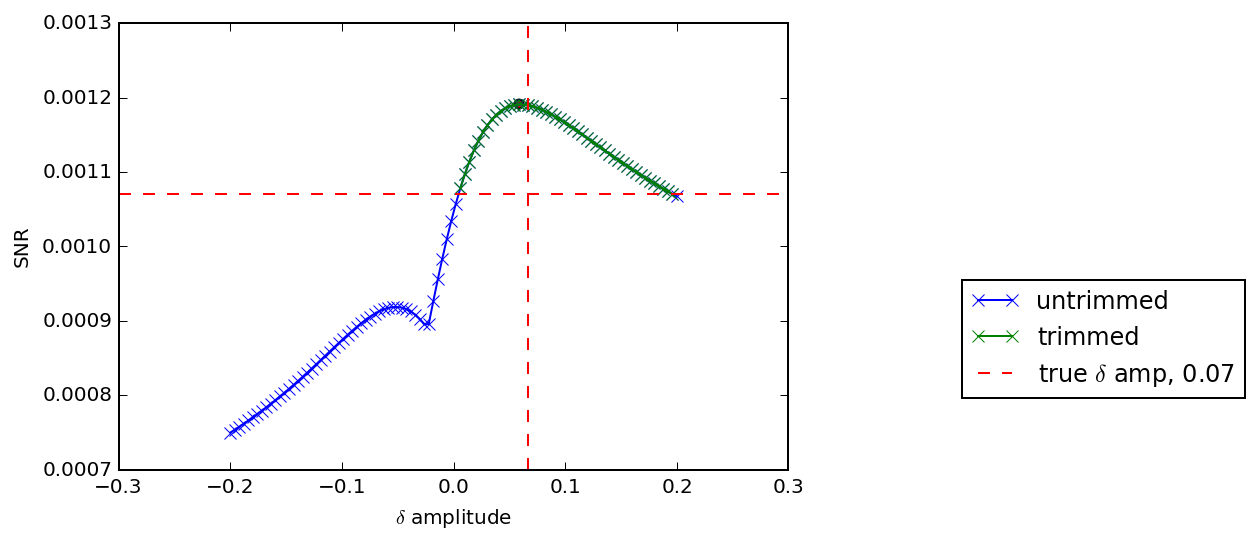

10 / 50 10
0.00149540037564


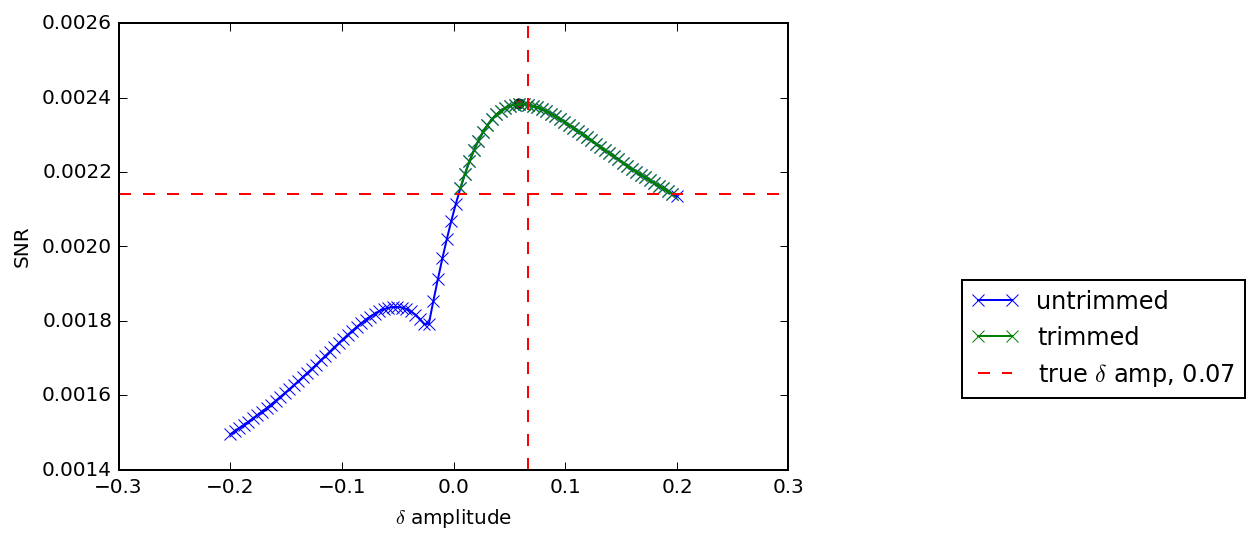

15 / 50 15
0.00224716995528


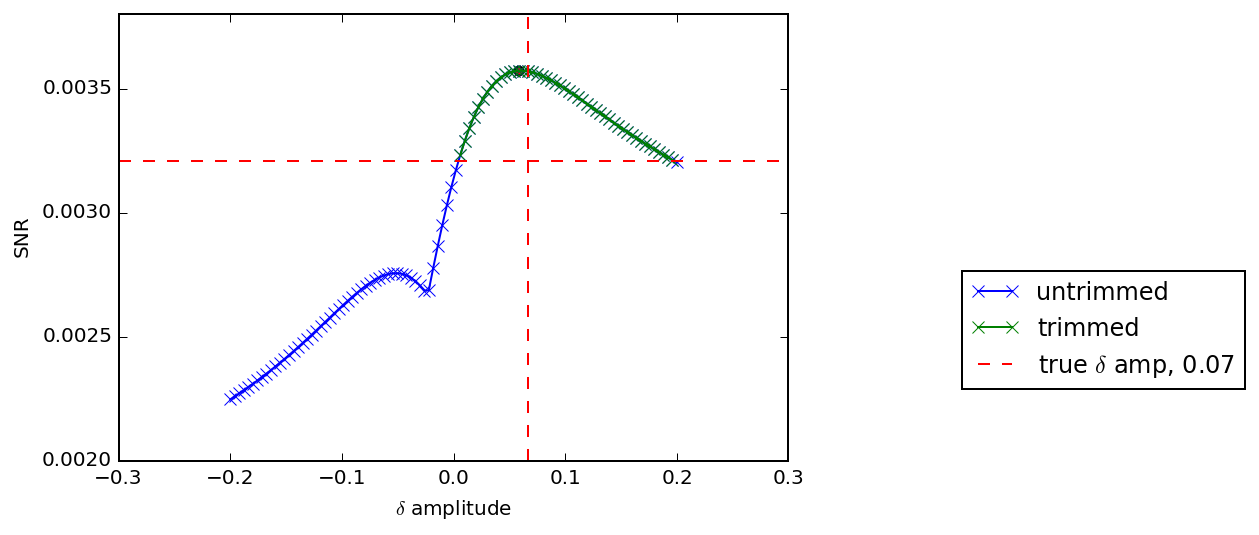

20 / 50 20
0.00299881942579


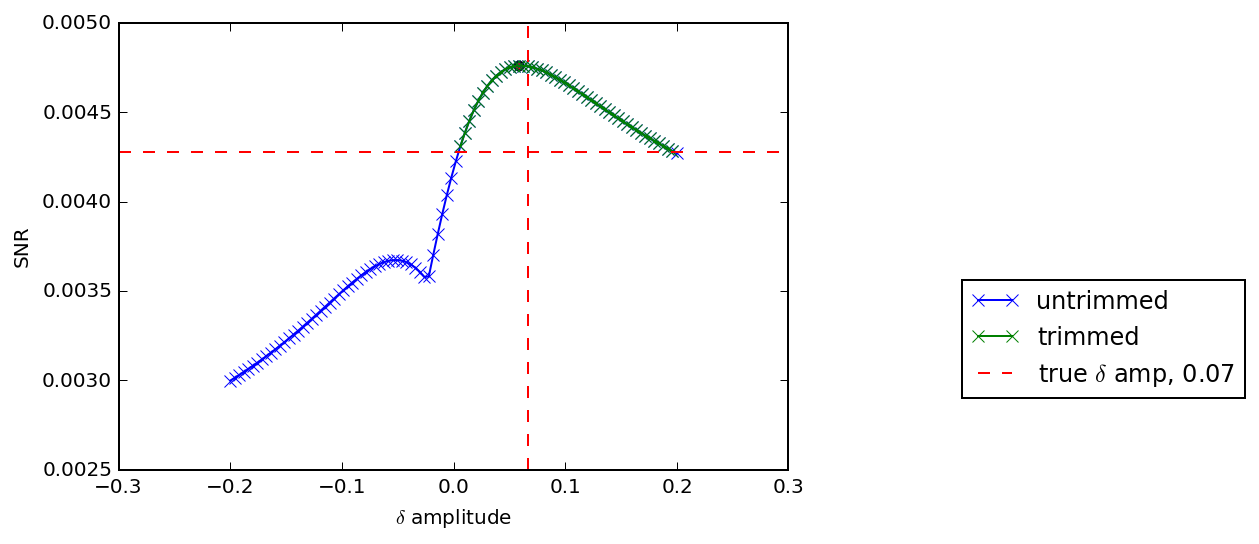

25 / 50 25
0.00375004319794


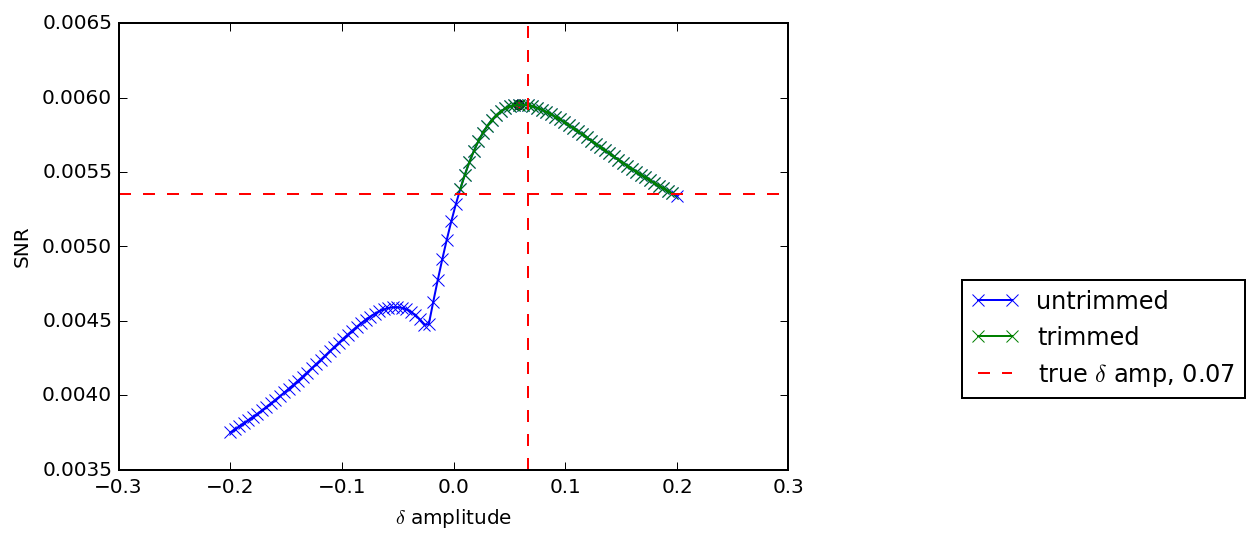

30 / 50 30
0.00449463933128


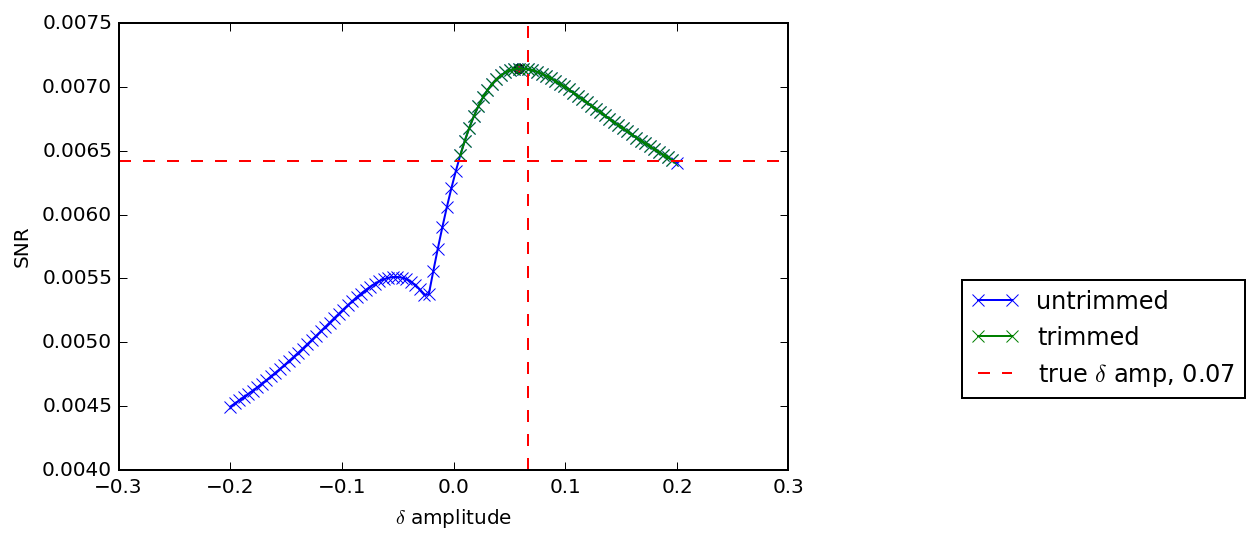

35 / 50 35
0.00518543438458


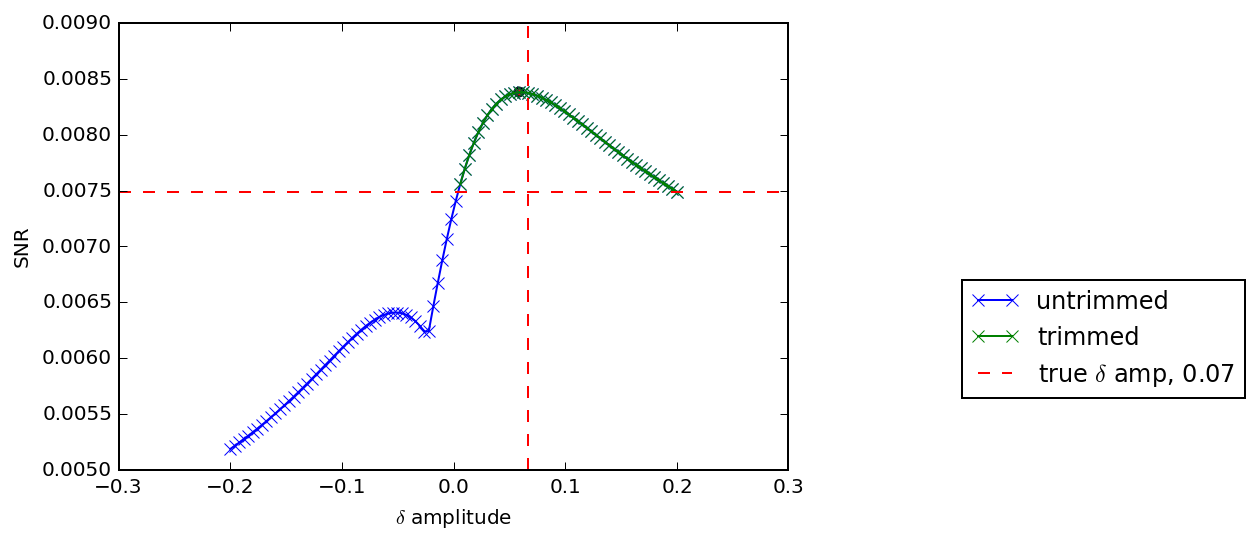

40 / 50 40
0.00599795137375


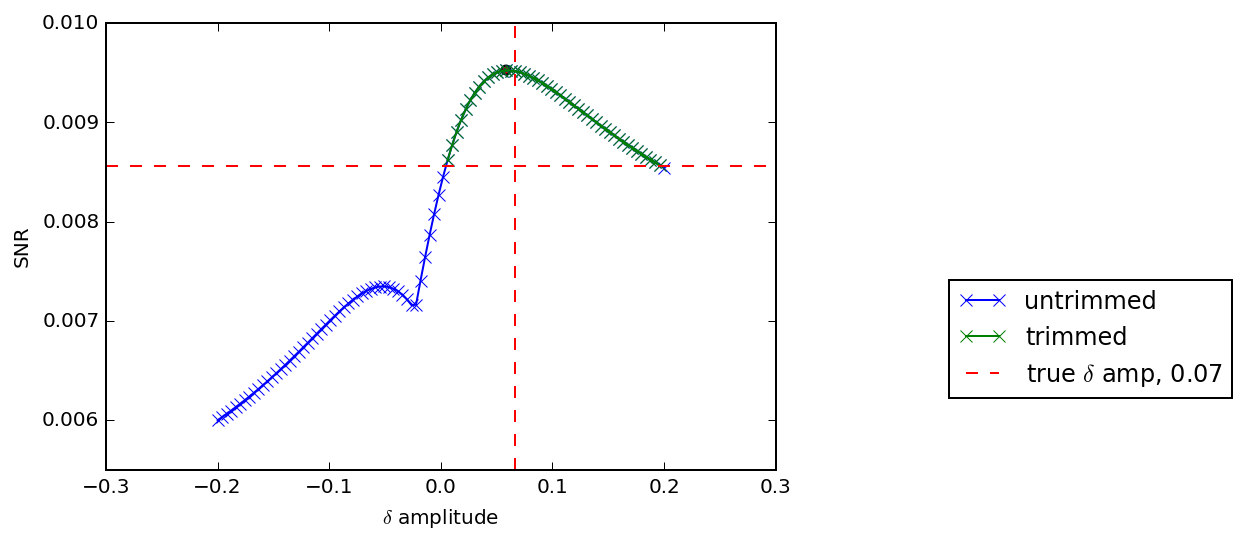

45 / 50 45
0.0067482371277


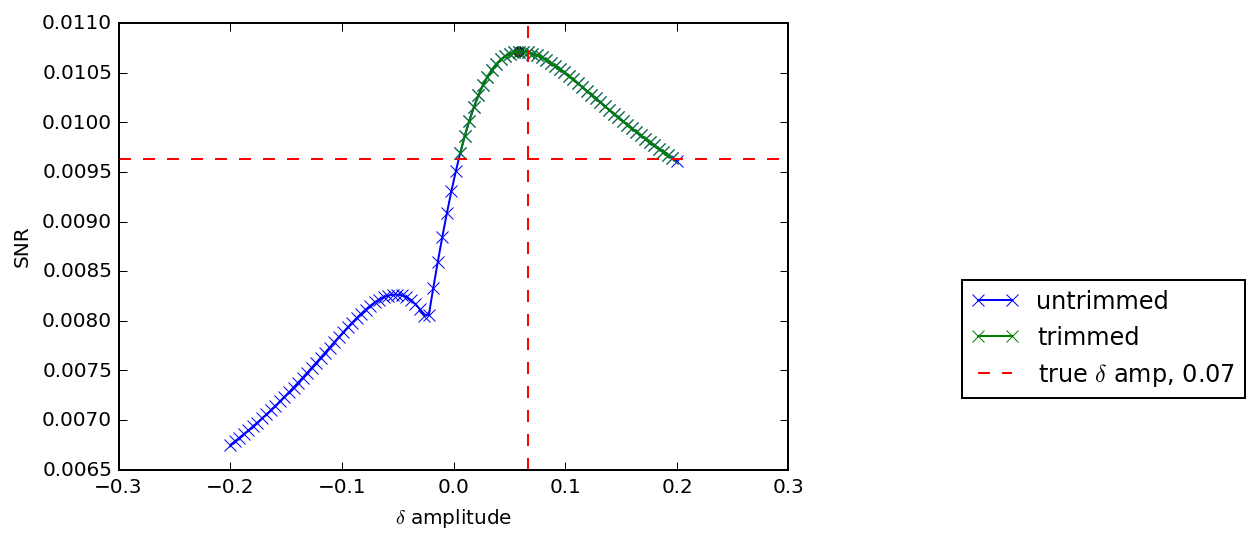

50 / 50 50
0.00749943214918


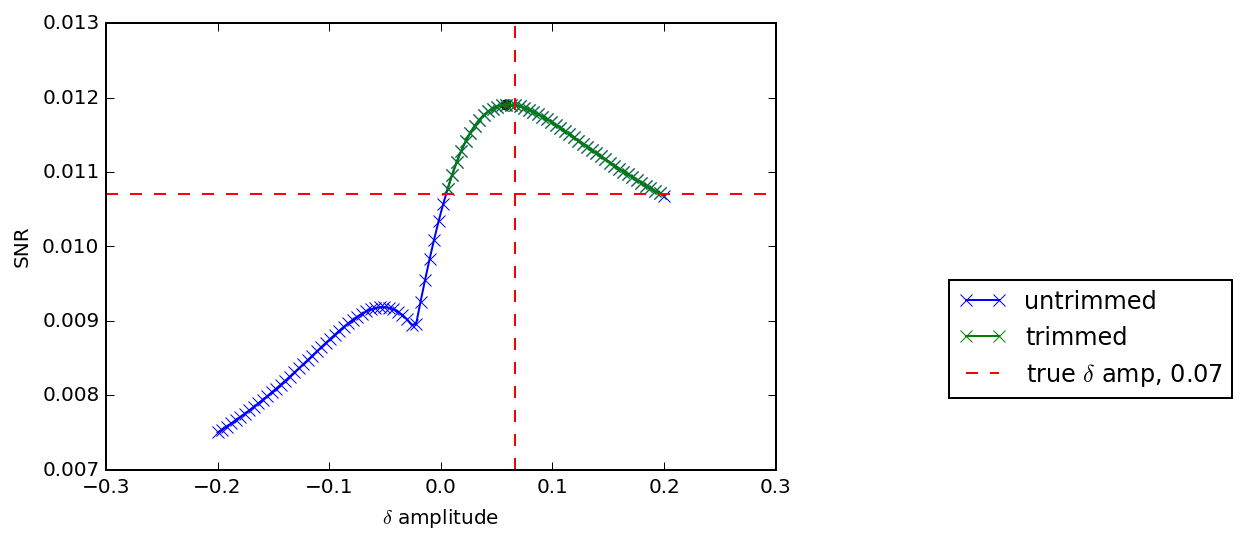

In [30]:
# plot N events vs parameter, with width
# there's a bug here somewhere

n_events_arr = np.linspace(0,N_events,11)
print(n_events_arr)

stacked_peaks = []
stacked_widths = []
for n in n_events_arr:
    print(len(snrs_arr[:int(n)]),'/',len(snrs_arr),int(n))#,snrs_arr[:int(n)])
    stacked = [np.sum(i) for i in zip(*normed_snrs_arr[:int(n)])]
    if stacked == []:
        stacked = normed_snrs_arr[0]
    stacked = np.array(stacked)/len(snrs_arr)
    print(stacked[0])
    trimmed_damps, trimmed_snrs = trim(stacked,damps, plots=True)
    width = getwidth(trimmed_damps)
    stacked_widths.append(width)
    peak = trimmed_damps[np.argmax(trimmed_snrs)]
    stacked_peaks.append(peak)


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


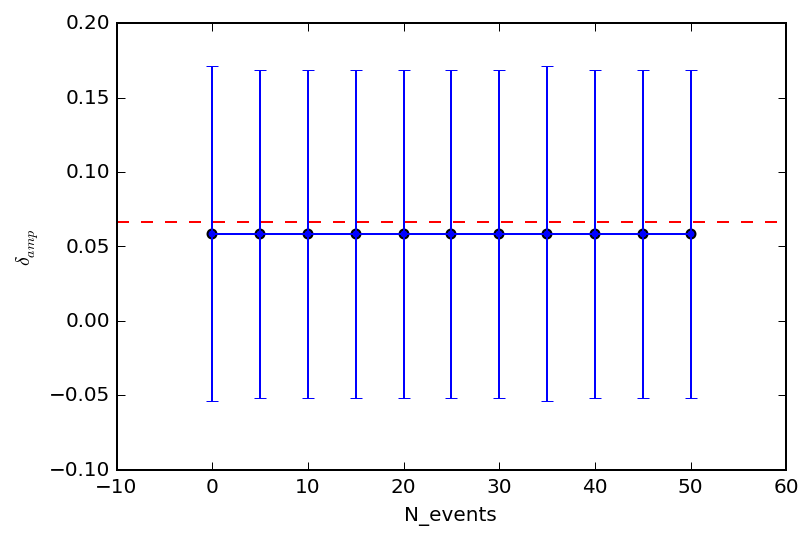

[0.11255263254290196, 0.11021987220655038, 0.11021987220655038, 0.11021987220655038, 0.11021987220655038, 0.11021987220655038, 0.11021987220655038, 0.11255263254290196, 0.11021987220655038, 0.11021987220655038, 0.11021987220655038]


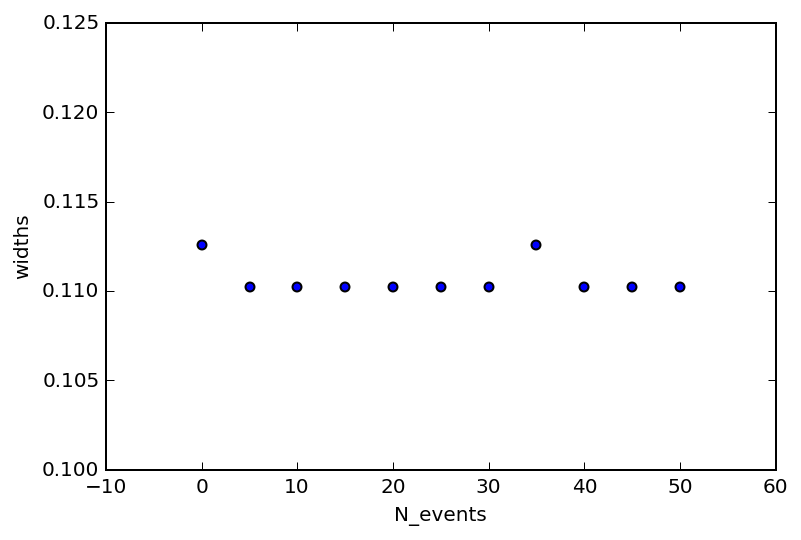

In [31]:
plt.figure()
plt.scatter(n_events_arr, stacked_peaks)
plt.errorbar(n_events_arr, stacked_peaks, yerr=stacked_widths)
plt.axhline(datatemplate.amp-1,xmin=0, xmax=450,linestyle='--',color='r', label="true amplitude, {0:.2f}".format(datatemplate.amp-1))
plt.xlabel('N_events')
plt.ylabel('$\delta_{amp}$')
plt.show()
print(stacked_widths)

plt.figure()
plt.scatter(n_events_arr, stacked_widths)
plt.xlabel('N_events')
plt.ylabel('widths')
plt.show()
